In [61]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from drone_model import DroneSimulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set the trajectory


In [62]:
# Time
dt = 0.1
fs = 1 / dt
T = 8.0
tsim = np.arange(0, T + dt/2, step=dt)

In [63]:
# Ambient wind speed & direction
w = 7.0 * np.ones_like(tsim)  # ambient wind speed magnitude
zeta = np.deg2rad(40.4) * np.ones_like(tsim)  # ambient wind direction

# Altitude
z = 2.0 * np.ones_like(tsim)  # altitude

# Velocity magnitude and direction
g = 2.0 * np.ones_like(tsim)
psi_global = np.deg2rad(90) * np.ones_like(tsim)  # start at 90°


# Index markers for time transitions
i1 = int(2.0 / dt)   # 2s -> switch to 30°
i2 = int(4.0 / dt)   # 4s -> start curve to 180°
i3 = int(5.2 / dt)   # 5.2s -> finish curve at 180°


# Step 2: After 2s, go to 30°
psi_global[i1:i2] = np.deg2rad(30)


# Step 3: Smooth curve from 30° to 180° over 1.2s
psi_global[i2:i3] = np.linspace(np.deg2rad(30), np.deg2rad(180), i3 - i2)


# Step 4: Hold 180° after 5.2s
psi_global[i3:] = np.deg2rad(180)




# Global frame x-y velocities
v_x_global = g * np.cos(psi_global)
v_y_global = g * np.sin(psi_global)

# Heading
psi = psi_global
#psi = psi_global[0] + (2*2*np.pi/T)*tsim
#psi = (np.pi/4) * np.ones_like(tsim)
#psi[30:] = psi[30] + np.pi/2

# Body-level frame x-y velocities
v_x = v_x_global * np.cos(psi) + v_y_global * np.sin(psi)
v_y = -v_x_global * np.sin(psi) + v_y_global * np.cos(psi)

# Simulate trajectory


In [64]:
mpc_horizon = 10
mpc_control_penalty = 1e-2

In [65]:
# Create simulator
simulator = DroneSimulator(dt=dt, mpc_horizon=mpc_horizon, r_u=mpc_control_penalty)

# Change parameters
print(simulator.params.__dict__.keys())
simulator.params.Mm = 2.0  # example change the mass

dict_keys(['g', 'm', 'M', 'Mm', 'L', 'R', 'I_x', 'I_y', 'I_z', 'b', 'd', 'C'])


In [66]:
# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta)

# Run
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
sim_data = pd.DataFrame(y_sim)
sim_data.insert(0, 'time', t_sim)
print('Done.')

Done.


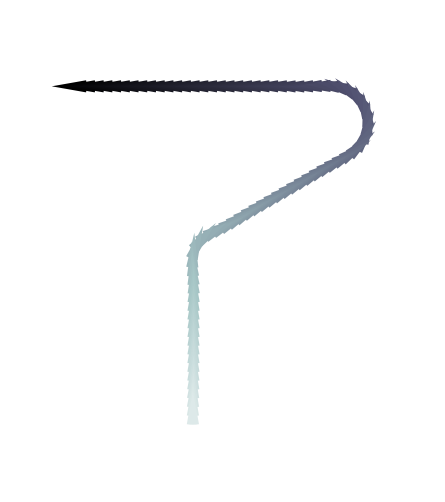

In [67]:
simulator.plot_trajectory(size_radius=0.8)

In [68]:
sim_data.to_csv("mirrorgames.csv", index=False)

